In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
import spconv.pytorch as spconv
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import f1_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
with h5py.File('data/train_xyze_1e4.h5', 'r') as f:
    # Access the dataset
    label_events = f['data']

    val_data = []

    data = []
    for i, event in enumerate(label_events):
        if i < 500:
            val_data.append(f['data'][i].reshape(-1,4))
            continue
        
        pts = f['data'][i].reshape(-1,4)
        data.append(pts)
    
#     n_signal_events = 0
    
#     n_michel_voxels = np.zeros(len(label_events))

#     # Iterate and print each event (which is a variable-length array)
#     for i, event in enumerate(label_events):
#         print(f"Event {i}: {event} (length = {len(event)})")
#         n_signal_events += np.any(event == 2)
#         n_michel_voxels[i] = np.sum(event == 2)

# # Corrected the misplaced parenthesis in the print statement
# print("Fraction of events with Michel electrons:", (n_signal_events / len(label_events)) * 100, "%")
# TODO normalize data

In [4]:
# Open the labels file
with h5py.File('data/train_label_1e4.h5', 'r') as f:
    # Access the dataset
    label_events = f['labels']
    
    labels = []
    val_labels = []

    for i, event in enumerate(label_events):
        if i < 500:
            val_labels.append(event)
            continue
    
        labels.append(event)

In [5]:
# Define the training truth labels
# 2 is the label for Michel electrons
truth = [(event_labels == 2).astype(np.int32) for event_labels in labels]
val_truth = [(event_labels == 2).astype(np.int32) for event_labels in val_labels]
# val_truth = torch.tensor([x for x_event in val_truth for x in x_event]).to(device)

In [6]:
# Input: sparse tensor with coordinates and features
# coordinates: Nx4 tensor (batch_idx, x, y, z)
# features: Nx1 tensor (voxel values)
# Iterate over the events and create sparse tensors
# Example input data

features = []
coords = []

# Iterate over all the events and create sparse tensors that are then merged
# For each input_coords, add another column for the batch index, which is just the index of the event
for i, input_event in enumerate(data):
    # Use the first event for demonstration
    # input_event = data[0]
    # Use the first three columns as coordinates
    input_coords = torch.tensor(input_event[:, :3], dtype=torch.int32)  
    input_coords = torch.cat((torch.full((input_coords.shape[0], 1), i, dtype=torch.int32), input_coords), dim=1)  # Add batch index
    # Use the fourth column as features
    input_feats = torch.tensor(input_event[:, 3], dtype=torch.float32).unsqueeze(1)
    
    features.append(input_feats)
    coords.append(input_coords)

val_features = []
val_coords = []
for i, input_event in enumerate(val_data):
    # Use the first event for demonstration
    # input_event = data[0]
    # Use the first three columns as coordinates
    input_coords = torch.tensor(input_event[:, :3], dtype=torch.int32)  
    input_coords = torch.cat((torch.full((input_coords.shape[0], 1), i, dtype=torch.int32), input_coords), dim=1)  # Add batch index
    # Use the fourth column as features
    input_feats = torch.tensor(input_event[:, 3], dtype=torch.float32).unsqueeze(1)
    
    val_features.append(input_feats)
    val_coords.append(input_coords)

In [7]:
input_feats = torch.cat(features, dim=0).to(device)
input_coords = torch.cat(coords, dim=0).to(device)

val_input_feats = torch.cat(val_features, dim=0).to(device)
val_input_coords = torch.cat(val_coords, dim=0).to(device)

In [8]:
scaler = StandardScaler()
input_feats_scaled = torch.tensor(scaler.fit_transform(input_feats.cpu().numpy()), dtype=torch.float32).to(device)
val_input_feats_scaled = torch.tensor(scaler.transform(val_input_feats.cpu().numpy()), dtype=torch.float32).to(device)

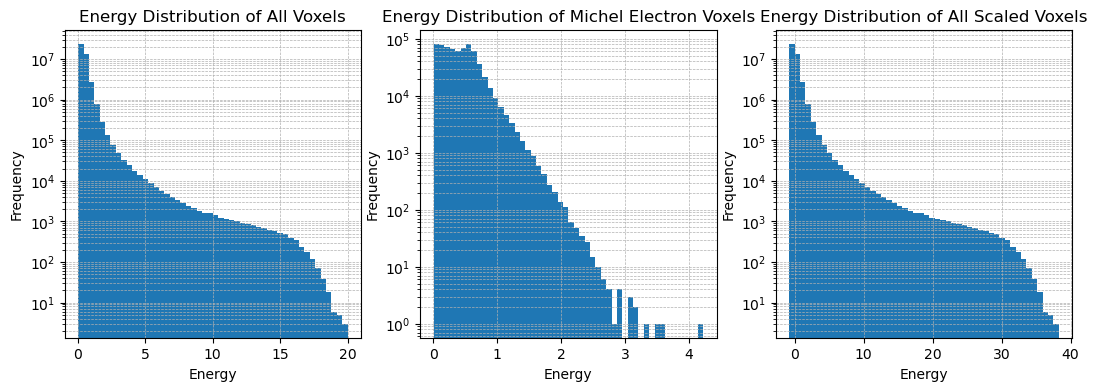

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
axs[0].hist(input_feats.cpu().numpy(), bins=50)
axs[0].set(title='Energy Distribution of All Voxels', xlabel='Energy', ylabel='Frequency')

axs[1].hist(np.concatenate([input_event[:, 3][label_event == 2] for input_event, label_event in zip(data, labels)]), bins=50)
axs[1].set(title='Energy Distribution of Michel Electron Voxels', xlabel='Energy', ylabel='Frequency')

axs[2].hist(input_feats_scaled.cpu().numpy(), bins=50)
axs[2].set(title='Energy Distribution of All Scaled Voxels', xlabel='Energy', ylabel='Frequency')

for ax in axs:
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

In [39]:
class AutoEncoder(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.encoder = spconv.SparseSequential(
            # TODO try submanifold convolution
            spconv.SparseConv3d(1, 1, 3, 2, algo=spconv.ConvAlgo.Native, indice_key="cp0"),
            spconv.SparseConv3d(1, 1, 3, 2, algo=spconv.ConvAlgo.Native, indice_key="cp1"),
            # TODO maxpooling
            # spconv.SparseMaxPool3d(kernel_size=2, stride=2, padding=0),
            # TODO batch normalization
            nn.ReLU(),
            spconv.SparseBatchNorm(1),
            spconv.SparseConv3d(1, 1, 3, 2, algo=spconv.ConvAlgo.Native, indice_key="cp2"),
            spconv.SparseConv3d(1, 1, 3, 2, algo=spconv.ConvAlgo.Native, indice_key="cp3"),
            # spconv.SparseMaxPool3d(kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            spconv.SparseBatchNorm(1),
        ).to(device)

        self.decoder = spconv.SparseSequential(
            spconv.SparseInverseConv3d(1, 1, 3, algo=spconv.ConvAlgo.Native, indice_key="cp3"), 
            spconv.SparseInverseConv3d(1, 1, 3, algo=spconv.ConvAlgo.Native, indice_key="cp2"), 
            nn.ReLU(),
            spconv.SparseBatchNorm(1),
            # spconv.SparseMaxPool3d(kernel_size=2, stride=2, padding=0),
            # nn.ReLU(),
            spconv.SparseInverseConv3d(1, 1, 3, algo=spconv.ConvAlgo.Native, indice_key="cp1"),
            spconv.SparseInverseConv3d(1, 1, 3, algo=spconv.ConvAlgo.Native, indice_key="cp0"),
        )
        self.shape = shape

    def forward(self, features, coors, batch_size):
        coors = coors.int()
        x = spconv.SparseConvTensor(features, coors, self.shape, batch_size)
        # print("Input shape:", x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# model.train()
# model(batch_input_feats, batch_input_coords, batch_size=batch_size)

In [42]:
def compute_validation_output(model, val_truth, val_input_feats, val_input_coords):
    """Compute the model output for the validation data"""
    val_batch_size = 100

    val_n_voxels = [len(e) for e in val_truth]
    val_n_voxels_cumsum = np.cumsum(val_n_voxels)

    preds = []

    for i, batch in enumerate(range(0, len(val_truth), val_batch_size)):
        voxel_i_lower = 0 if batch == 0 else val_n_voxels_cumsum[batch - 1]
        voxel_i_upper = val_n_voxels_cumsum[batch + val_batch_size-1] if (batch + val_batch_size-1) < len(val_truth) else val_n_voxels_cumsum[-1]
        batch_input_feats = val_input_feats[voxel_i_lower:voxel_i_upper]
        batch_input_coords = val_input_coords[voxel_i_lower:voxel_i_upper].detach().clone()
        
        # From batch_input_coords, subtract the batch number to make indices start from 0
        batch_input_coords[:, 0] = batch_input_coords[:, 0] - batch
        # Defensive: skip if batch_input_coords is empty
        if batch_input_coords.shape[0] == 0:
            print("Empty batch. Skip")
            continue

        # Defensive: check max batch index only if not empty
        # if batch_input_coords.shape[0] > 0:
            # assert batch_input_coords[:, 0].max().item() == val_batch_size - 1, batch_input_coords[:, 0].max().item()
            # assert batch_input_coords[:, 0].min().item() == 0, batch_input_coords[:, 0].min().item()
        
        model.eval()
        with torch.no_grad():
            output_sparse = model(batch_input_feats, batch_input_coords, batch_size=val_batch_size if batch + val_batch_size < len(data) else len(data) - batch)

            preds.append(output_sparse.features)

    preds = torch.cat(preds, dim=0)
    
    return preds

In [ ]:
model = AutoEncoder([767, 767, 767]).to(device)

# train model using the truth labels
n_voxels = [len(t) for t in truth]
n_voxels_cumsum = np.cumsum(n_voxels)
val_truth_flat = np.concatenate(val_truth)

n_epochs = 100
loss_per_epoch = np.zeros(n_epochs)
val_loss_per_epoch = np.zeros(n_epochs)

loss_fn = nn.BCEWithLogitsLoss()

batch_size = 32  # Define batch size
# batch_size = 100
batch_indices = range(0, len(data), batch_size)

for epoch in range(n_epochs):  # Example training loop
    loss_per_batch = np.zeros(len(batch_indices))

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for i, batch in enumerate(tqdm(batch_indices)):  # Batch size of 5
        voxel_i_lower = 0 if batch == 0 else n_voxels_cumsum[batch - 1]
        voxel_i_upper = n_voxels_cumsum[batch + batch_size-1] if (batch + batch_size-1) < len(data) else n_voxels_cumsum[-1]

        batch_input_feats = input_feats[voxel_i_lower:voxel_i_upper]
        batch_input_coords = input_coords[voxel_i_lower:voxel_i_upper].detach().clone()
        # From batch_input_coords, subtract the batch number to make indices start from 0
        batch_input_coords[:, 0] = batch_input_coords[:, 0] - batch

        # Defensive: skip if batch_input_coords is empty
        if batch_input_coords.shape[0] == 0:
            print("Empty batch. Skip")
            continue

        batch_truth = torch.tensor(np.concatenate(truth[batch:batch+batch_size]), dtype=torch.float32).unsqueeze(1).to(device)

        model.train()
        optimizer.zero_grad()
        output_sparse = model(batch_input_feats, batch_input_coords, batch_size=batch_size if batch + batch_size < len(data) else len(data) - batch)
        loss = loss_fn(output_sparse.features, batch_truth)
        if torch.isnan(loss):
            print(output_sparse.features)

        loss.backward()
        optimizer.step()
        loss_per_batch[i] = loss.detach().clone().item()
    
    # Save the loss
    loss_per_epoch[epoch] = np.nanmean(loss_per_batch)

    val_model_output = compute_validation_output(model, val_truth, val_input_feats, val_input_coords)
    # Replace nan values with 0
    val_model_output[torch.isnan(val_model_output)] = 0

    val_loss_per_epoch[epoch] = loss_fn(val_model_output, torch.tensor(val_truth_flat, dtype=torch.float).unsqueeze(1).to(device))
    
    # Save a copy of the model every epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")


 45%|████▌     | 134/297 [00:10<00:13, 12.31it/s]

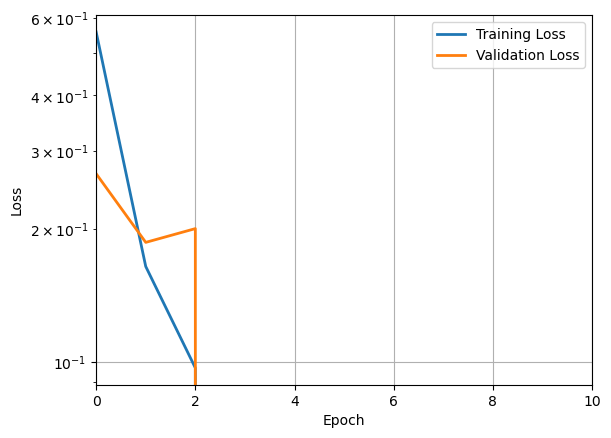

In [47]:
plt.plot(range(n_epochs), loss_per_epoch, lw=2, label="Training Loss")
plt.plot(range(n_epochs), val_loss_per_epoch, lw=2, label="Validation Loss")
plt.xlim(0, 10)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.yscale("log")

In [138]:
# Compute the F1 score for the validation data
val_batch_size = 100
sigmoid = torch.nn.Sigmoid()

preds = []

for i, batch in enumerate(range(0, len(val_data), val_batch_size)):
    voxel_i_lower = 0 if batch == 0 else val_n_voxels_cumsum[batch - 1]
    voxel_i_upper = val_n_voxels_cumsum[batch + val_batch_size-1] if (batch + val_batch_size-1) < len(val_data) else val_n_voxels_cumsum[-1]
    batch_input_feats = val_input_feats[voxel_i_lower:voxel_i_upper]
    batch_input_coords = val_input_coords[voxel_i_lower:voxel_i_upper].detach().clone()
    
    print(batch_input_coords[:, 0].min().item(), batch_input_coords[:, 0].max().item())
    # From batch_input_coords, subtract the batch number to make indices start from 0
    batch_input_coords[:, 0] = batch_input_coords[:, 0] - batch
    # Defensive: skip if batch_input_coords is empty
    if batch_input_coords.shape[0] == 0:
        print("Empty batch. Skip")
        continue

    # Defensive: check max batch index only if not empty
    # if batch_input_coords.shape[0] > 0:
        # assert batch_input_coords[:, 0].max().item() == val_batch_size - 1, batch_input_coords[:, 0].max().item()
        # assert batch_input_coords[:, 0].min().item() == 0, batch_input_coords[:, 0].min().item()
    
    model.eval()
    with torch.no_grad():
        output_sparse = model(batch_input_feats, batch_input_coords, batch_size=val_batch_size)
    
        preds.append(sigmoid(output_sparse.features))

preds = torch.cat(preds, dim=0).squeeze()

0 99
SPCONV_DEBUG_SAVE_PATH not found, you can specify SPCONV_DEBUG_SAVE_PATH as debug data save path to save debug data which can be attached in a issue.


[Exception|native_pair]indices=torch.Size([412310, 4]),bs=100,ss=[767, 767, 767],algo=ConvAlgo.Native,ksize=[3, 3, 3],stride=[2, 2, 2],padding=[0, 0, 0],dilation=[1, 1, 1],subm=False,transpose=False


OutOfMemoryError: CUDA out of memory. Tried to allocate 90.00 MiB. GPU 0 has a total capacity of 3.81 GiB of which 89.75 MiB is free. Including non-PyTorch memory, this process has 3.71 GiB memory in use. Of the allocated memory 3.23 GiB is allocated by PyTorch, and 426.22 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [110]:
preds.shape, np.concatenate(val_truth).shape

(torch.Size([2187515]), (2187515,))

In [113]:
f1s = []
f1_thresholds = np.arange(0, 1, 0.1)

for threshold in f1_thresholds:
    f1s.append(
        f1_score(
            np.concatenate(val_truth),
            preds.cpu().numpy() > threshold,
        )
    )

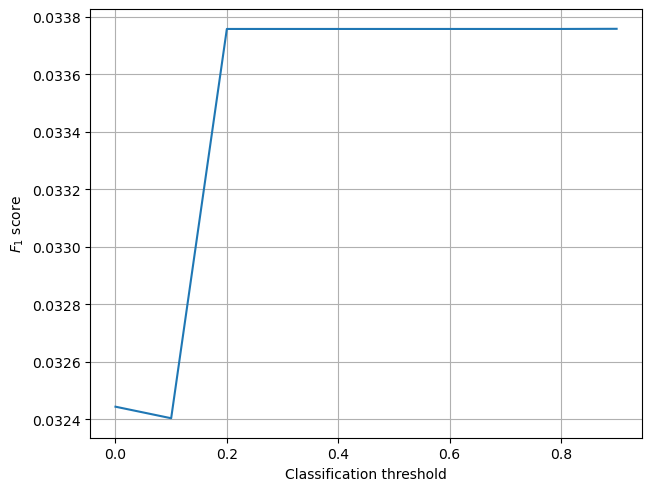

In [ ]:
fig, ax = plt.subplots(layout="constrained")

ax.plot(f1_thresholds, f1s)
ax.set(xlabel="Classification threshold", ylabel="$F_1$ score")
ax.grid()

[Text(0.5, 0, 'Neural network output'), Text(0, 0.5, 'Number of voxels')]

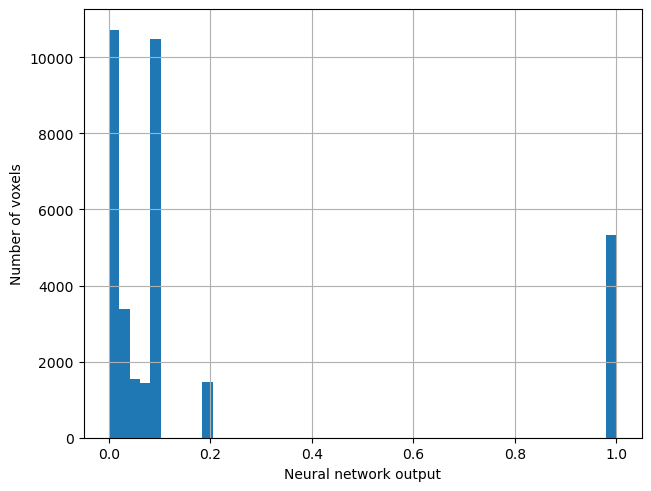

In [128]:
fig, ax = plt.subplots(layout="constrained")

ax.hist(preds[np.concatenate(val_truth) == 1].cpu().numpy(), bins=np.linspace(0, 1, 50))
ax.grid()
ax.set(xlabel="Neural network output", ylabel="Number of voxels")

In [124]:
torch.mean(torch.isnan(preds).double())

tensor(0.0479, device='cuda:0', dtype=torch.float64)

In [127]:
torch.mean((preds > 0.9).double())

tensor(0.1278, device='cuda:0', dtype=torch.float64)